In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pathlib
import random
import os

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

#Suppressing Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
tf.keras.backend.clear_session()

# Preprocessing

In [ ]:
train_path = '/content/Covid19-dataset/train'
test_path = '/content/Covid19-dataset/test'

In [ ]:
img_size = 224
batch = 16

# Image Loader

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.)
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch,
        shuffle=True,
        seed=42,
        class_mode='categorical',
        target_size=(img_size, img_size),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator

In [ ]:
train_generator = generate_data(train_path)

test_generator = generate_data(test_path)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


# Modelling

In [ ]:
base_model = NASNetMobile(weights='imagenet', include_top=False,
                            input_shape=(img_size, img_size,3))

# freeze extraction layers
base_model.trainable = False

# add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512 , activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# confirm unfrozen layers
for layer in model.layers:
    if layer.trainable==True:
        print(layer)

19993432/19993432 [==============================] - 2s 0us/step


## Save best model during training

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),
                ModelCheckpoint('model.hdf5',
                                 save_best_only=True)]

In [ ]:
opt = Adam(learning_rate=0.001)
model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)

# Training the Model

In [ ]:
history = model.fit(train_generator,
                    epochs = 100,
                    validation_data = test_generator,
                    verbose = True,
                   callbacks=callbacks)

Epoch 1/100
16/16 [==============================] - 28s 1s/step - loss: 0.8217 - accuracy: 0.6733 - val_loss: 0.7612 - val_accuracy: 0.6364
Epoch 2/100
16/16 [==============================] - 12s 721ms/step - loss: 0.2973 - accuracy: 0.8924 - val_loss: 0.7835 - val_accuracy: 0.6364
Epoch 3/100
16/16 [==============================] - 12s 737ms/step - loss: 0.2376 - accuracy: 0.9203 - val_loss: 0.4274 - val_accuracy: 0.8030
Epoch 4/100
16/16 [==============================] - 12s 772ms/step - loss: 0.1380 - accuracy: 0.9522 - val_loss: 0.3975 - val_accuracy: 0.8485
Epoch 5/100
16/16 [==============================] - 12s 771ms/step - loss: 0.0940 - accuracy: 0.9801 - val_loss: 0.3618 - val_accuracy: 0.8788
Epoch 6/100
16/16 [==============================] - 12s 735ms/step - loss: 0.0693 - accuracy: 0.9880 - val_loss: 0.3701 - val_accuracy: 0.8636
Epoch 7/100
16/16 [==============================] - 11s 683ms/step - loss: 0.0569 - accuracy: 0.9880 - val_loss: 0.3925 - val_accuracy: 0.

# Evaluation

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### Loading our best model

In [ ]:
model = load_model('./model.hdf5')

In [ ]:
def learning_curve(model_fit, key='accuracy', ylim=(0, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'val'], loc='best')
    plt.show()

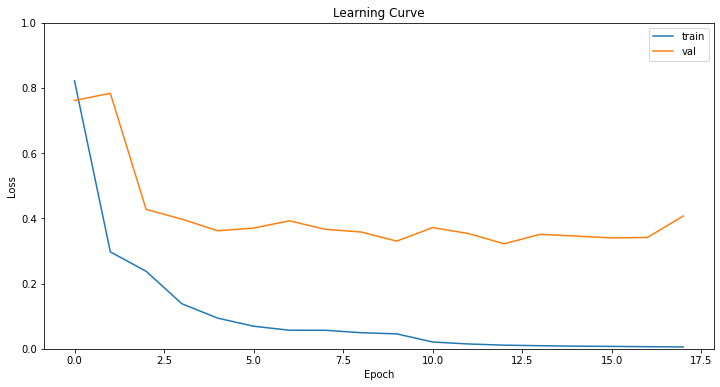

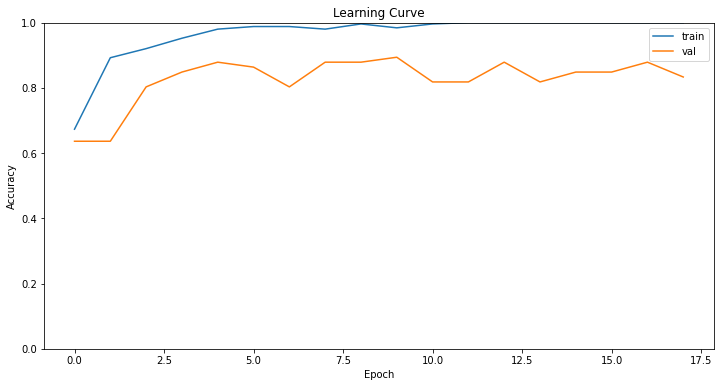

In [ ]:
learning_curve(history,'loss', ylim=(0,1))
learning_curve(history, 'accuracy', ylim=(0,1))

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print('Loss: %.3f' % (test_loss * 100.0))
print('Accuracy: %.3f' % (test_acc * 100.0)) 

5/5 [==============================] - 5s 244ms/step - loss: 0.3220 - accuracy: 0.8788
Loss: 32.203
Accuracy: 87.879
